<a href="https://colab.research.google.com/github/iaravagni/adversarial-face-patch/blob/iara/notebooks/adversarial_attack_GC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda

DOWNLOADING FACE DATASET
Loading LFW dataset...
✓ Dataset loaded: 13233 images of 5749 people

DATASET ASSIGNMENT
Employee_1: George W Bush (530 images)
Employee_2: Colin Powell (236 images)
Employee_3: Tony Blair (144 images)
Attacker: Donald Rumsfeld (121 images)

✓ Employee_1: 530 images loaded

✓ Employee_2: 236 images loaded

✓ Employee_3: 144 images loaded
✓ Attacker: 121 images loaded

IMAGE CONFIGURATION
Employee database: 40 images per employee
Attacker training: 30 images
Attacker testing: 10 images

✓ Using 30 images for patch optimization
✓ Using 10 images for attack testing

INITIALIZING FACE RECOGNITION MODEL
✓ Face recognition model loaded!

BUILDING EMPLOYEE DATABASE

Processing Employee_1...
  ✓ Employee_1: 40 images processed (requested: 40)

Processing Employee_2...
  ✓ Employee_2: 40 images processed (requested: 40)

Processing Employee_3...
  ✓ Employee_3: 40 images processed (requested: 40)

✓ Employee database ready with 3 employees

BASELINE:

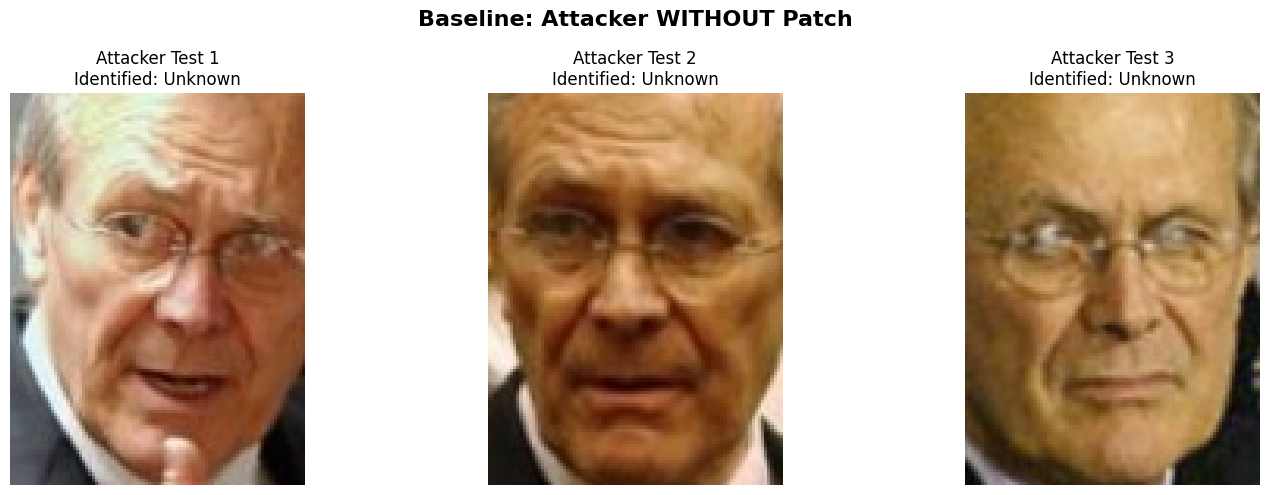


CREATING ADVERSARIAL CIRCULAR PATCH
Target: Impersonate Employee_1

Forehead search area:
  X range: [30, 130] (width: 100px)
  Y range: [0, 30] (height: 30px)
Optimizer learning rates:
  Patch content: 0.2
  Position (x, y): 3.0

Preparing attacker training images...
  ✓ Image 1 processed
  ✓ Image 2 processed
  ✓ Image 3 processed
  ✓ Image 4 processed
  ✓ Image 5 processed
  ✓ Image 6 processed
  ✓ Image 7 processed
  ✓ Image 8 processed
  ✓ Image 9 processed
  ✓ Image 10 processed
  ✓ Image 11 processed
  ✓ Image 12 processed
  ✓ Image 13 processed
  ✓ Image 14 processed
  ✓ Image 15 processed
  ✓ Image 16 processed
  ✓ Image 17 processed
  ✓ Image 18 processed
  ✓ Image 19 processed
  ✓ Image 20 processed
  ✓ Image 21 processed
  ✓ Image 22 processed
  ✓ Image 23 processed
  ✓ Image 24 processed
  ✓ Image 25 processed
  ✓ Image 26 processed
  ✓ Image 27 processed
  ✓ Image 28 processed
  ✓ Image 29 processed
  ✓ Image 30 processed

✓ Optimizing circular patch on 30 attacker image

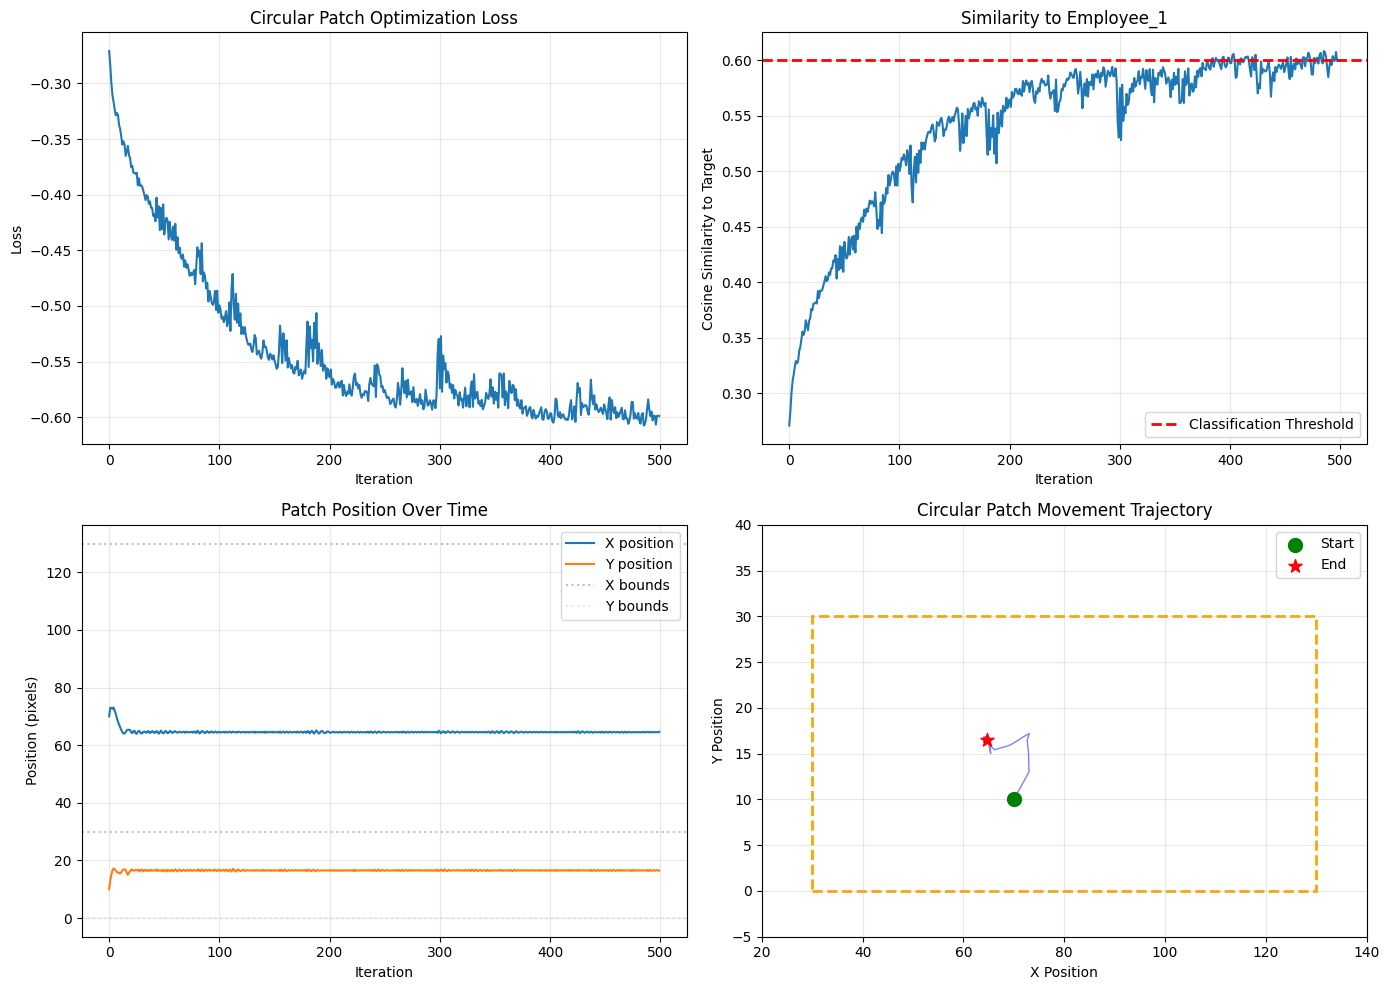

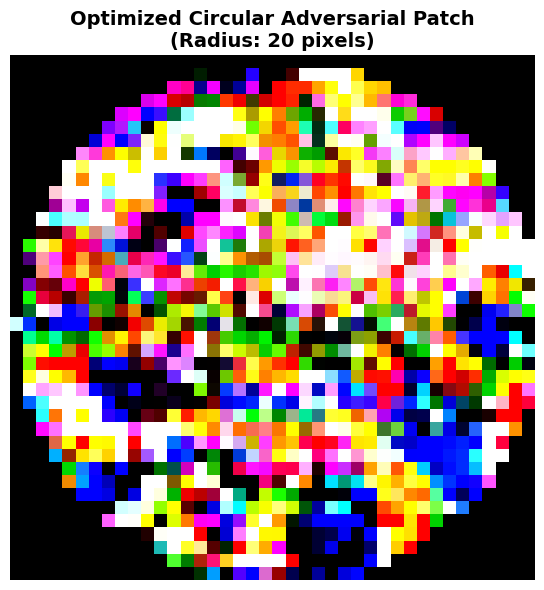


CIRCULAR PATCH PLACEMENT VISUALIZATION


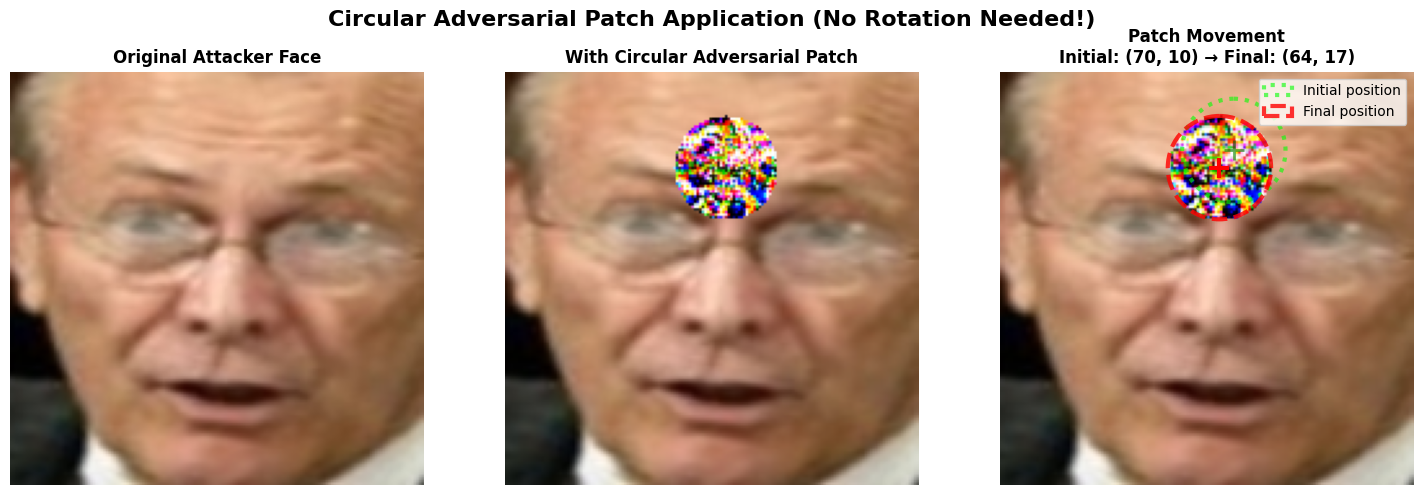


✓ Circular patch placed at optimized position (64, 17)
  Face size: 160x160 pixels
  Patch covers: 4.9% of face area
  Position moved by: Δx=-5.6px, Δy=6.7px

ATTACK: ATTACKER WITH CIRCULAR ADVERSARIAL PATCH

Testing attacker image 1 with circular patch...
  Similarity to Employee_1: 0.556
  Similarity to Employee_2: 0.026
  Similarity to Employee_3: 0.322
✓ Result: Unknown (confidence: 0.556)
Expected: Employee_1 ✗

Testing attacker image 2 with circular patch...
  Similarity to Employee_1: 0.635
  Similarity to Employee_2: 0.041
  Similarity to Employee_3: 0.360
✓ Result: Employee_1 (confidence: 0.635)
Expected: Employee_1 ✓

Testing attacker image 3 with circular patch...
  Similarity to Employee_1: 0.499
  Similarity to Employee_2: -0.007
  Similarity to Employee_3: 0.247
✓ Result: Unknown (confidence: 0.499)
Expected: Employee_1 ✗

Testing attacker image 4 with circular patch...
  Similarity to Employee_1: 0.642
  Similarity to Employee_2: -0.038
  Similarity to Employee_3: 0.298

In [57]:
# Adversarial Face Recognition Attack - CIRCULAR PATCH VERSION
# Cybersecurity Class Assignment
# Run this in Google Colab

# ============================================================================
# SETUP & INSTALLATION
# ============================================================================

!pip install facenet-pytorch pillow matplotlib torch torchvision numpy scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# DOWNLOAD AND PREPARE DATASET
# ============================================================================

print("\n" + "="*70)
print("DOWNLOADING FACE DATASET")
print("="*70)

# Load LFW (color)
print("Loading LFW dataset...")
lfw = fetch_lfw_people(color=True, resize=1.0)
imgs = lfw.images          # (N,H,W,3), float64
targets = lfw.target       # integer labels
n_samples = imgs.shape[0]
target_names = lfw.target_names

print(f"✓ Dataset loaded: {n_samples} images of {len(target_names)} people")

# Select people with most images (for employees and attacker)
unique, counts = np.unique(targets, return_counts=True)
sorted_idx = np.argsort(-counts)

# We need 4 people: 3 employees + 1 attacker
NUM_PEOPLE = 4
selected_ids = unique[sorted_idx[:NUM_PEOPLE]]

print("\n" + "="*70)
print("DATASET ASSIGNMENT")
print("="*70)

# Assign roles
employee_ids = selected_ids[:NUM_PEOPLE-1]
attacker_id = selected_ids[NUM_PEOPLE-1]

for i, emp_id in enumerate(employee_ids):
    emp_name = target_names[emp_id]
    emp_count = counts[sorted_idx[i]]
    print(f"Employee_{i+1}: {emp_name} ({emp_count} images)")

attacker_name = target_names[attacker_id]
attacker_count = counts[sorted_idx[3]]
print(f"Attacker: {attacker_name} ({attacker_count} images)")

# Organize images by person
def get_images_for_person(person_id):
    """Get all images for a specific person"""
    indices = np.where(targets == person_id)[0]
    person_images = []
    for idx in indices:
        # Convert to PIL Image
        # LFW images are in range [0, 1] as float, need to scale to [0, 255]
        img_array = imgs[idx]

        # Check if image needs scaling
        if img_array.max() <= 1.0:
            img_array = (img_array * 255).astype(np.uint8)
        else:
            img_array = img_array.astype(np.uint8)

        pil_img = Image.fromarray(img_array)
        person_images.append(pil_img)
    return person_images

# Get images for employees
employee_images = {}
for i, emp_id in enumerate(employee_ids):
    emp_label = f"Employee_{i+1}"
    employee_images[emp_label] = get_images_for_person(emp_id)
    print(f"\n✓ {emp_label}: {len(employee_images[emp_label])} images loaded")

# Get images for attacker
attacker_all_images = get_images_for_person(attacker_id)
print(f"✓ Attacker: {len(attacker_all_images)} images loaded")

# ============================================================================
# CONFIGURE NUMBER OF IMAGES TO USE
# ============================================================================
print("\n" + "="*70)
print("IMAGE CONFIGURATION")
print("="*70)

# Configure how many images to use
NUM_EMPLOYEE_IMAGES = 40  # Number of images per employee for database (increase for better recognition)
NUM_ATTACKER_TRAIN = 30   # Number of attacker images for patch optimization (more = better generalization)
NUM_ATTACKER_TEST = 10     # Number of attacker images for testing attack

print(f"Employee database: {NUM_EMPLOYEE_IMAGES} images per employee")
print(f"Attacker training: {NUM_ATTACKER_TRAIN} images")
print(f"Attacker testing: {NUM_ATTACKER_TEST} images")

# Split attacker images
attacker_train_images = attacker_all_images[:NUM_ATTACKER_TRAIN]
attacker_test_images = attacker_all_images[NUM_ATTACKER_TRAIN:NUM_ATTACKER_TRAIN + NUM_ATTACKER_TEST]

print(f"\n✓ Using {len(attacker_train_images)} images for patch optimization")
print(f"✓ Using {len(attacker_test_images)} images for attack testing")

# ============================================================================
# INITIALIZE FACE RECOGNITION MODEL
# ============================================================================

print("\n" + "="*70)
print("INITIALIZING FACE RECOGNITION MODEL")
print("="*70)

# MTCNN for face detection
mtcnn = MTCNN(image_size=160, margin=20, device=device, keep_all=False)

# InceptionResnetV1 for face recognition (pretrained on VGGFace2)
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
print("✓ Face recognition model loaded!")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_face_embedding(img):
    """Extract face embedding from PIL Image"""
    # Detect and crop face
    face = mtcnn(img)
    if face is None:
        return None

    # Get embedding
    face = face.unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(face)
    return embedding

def cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between embeddings"""
    return torch.nn.functional.cosine_similarity(emb1, emb2).item()

def classify_face(test_embedding, employee_embeddings, threshold=0.6):
    """
    Classify face as employee or unknown
    threshold: cosine similarity threshold (higher = more strict)
    """
    max_similarity = -1
    identified_as = "Unknown"

    for name, emb in employee_embeddings.items():
        similarity = cosine_similarity(test_embedding, emb)
        print(f"  Similarity to {name}: {similarity:.3f}")

        if similarity > max_similarity:
            max_similarity = similarity
            if similarity > threshold:
                identified_as = name

    return identified_as, max_similarity

# ============================================================================
# BUILD EMPLOYEE DATABASE
# ============================================================================

print("\n" + "="*70)
print("BUILDING EMPLOYEE DATABASE")
print("="*70)

employee_embeddings = {}

for emp_id, img_list in employee_images.items():
    print(f"\nProcessing {emp_id}...")
    embeddings = []

    # Use NUM_EMPLOYEE_IMAGES for each employee
    num_to_use = min(NUM_EMPLOYEE_IMAGES, len(img_list))
    for img in img_list[:num_to_use]:
        try:
            emb = get_face_embedding(img)
            if emb is not None:
                embeddings.append(emb)
        except Exception as e:
            print(f"  Skipping image: {e}")

    # Average embeddings for this employee
    if embeddings:
        avg_embedding = torch.mean(torch.stack(embeddings), dim=0)
        employee_embeddings[emp_id] = avg_embedding
        print(f"  ✓ {emp_id}: {len(embeddings)} images processed (requested: {num_to_use})")

print(f"\n✓ Employee database ready with {len(employee_embeddings)} employees")

# ============================================================================
# BASELINE TEST: Attacker WITHOUT Patch (Should be "Unknown")
# ============================================================================

print("\n" + "="*70)
print("BASELINE: ATTACKER WITHOUT PATCH")
print("="*70)

baseline_results = []

for idx, test_img in enumerate(attacker_test_images):
    try:
        test_embedding = get_face_embedding(test_img)

        if test_embedding is not None:
            print(f"\nTesting attacker image {idx+1}...")
            identified, confidence = classify_face(test_embedding, employee_embeddings, threshold=0.6)
            baseline_results.append((identified, confidence))
            print(f"✓ Result: {identified} (confidence: {confidence:.3f})")
            print("Expected: Unknown", "✓" if identified == "Unknown" else "✗")

    except Exception as e:
        print(f"Error: {e}")

# Display test images
if attacker_test_images:
    try:
        n_imgs = min(3, len(attacker_test_images))
        fig, axes = plt.subplots(1, n_imgs, figsize=(5*n_imgs, 5))
        if n_imgs == 1:
            axes = [axes]

        for idx in range(n_imgs):
            axes[idx].imshow(attacker_test_images[idx])
            result_text = baseline_results[idx][0] if idx < len(baseline_results) else 'N/A'
            axes[idx].set_title(f"Attacker Test {idx+1}\nIdentified: {result_text}", fontsize=12)
            axes[idx].axis('off')

        plt.suptitle("Baseline: Attacker WITHOUT Patch", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Display error: {e}")

# ============================================================================
# CREATE ADVERSARIAL CIRCULAR PATCH
# ============================================================================

print("\n" + "="*70)
print("CREATING ADVERSARIAL CIRCULAR PATCH")
print("="*70)

# Target employee (the one we want to impersonate)
target_employee = list(employee_embeddings.keys())[0]  # First employee
target_embedding = employee_embeddings[target_employee]

print(f"Target: Impersonate {target_employee}")

# Initialize CIRCULAR patch
patch_radius = 20  # Radius of the circular patch
patch_size = patch_radius * 2  # Bounding box size

# Create circular mask (fixed, not learnable)
y_grid, x_grid = torch.meshgrid(
    torch.arange(patch_size, dtype=torch.float32, device=device) - patch_radius,
    torch.arange(patch_size, dtype=torch.float32, device=device) - patch_radius,
    indexing='ij'
)
circular_mask = (x_grid**2 + y_grid**2 <= patch_radius**2).float()
circular_mask = circular_mask.unsqueeze(0)  # [1, H, W]

# Initialize patch content (only pixels inside circle will be used)
patch = torch.rand(3, patch_size, patch_size, requires_grad=True, device=device) * 0.5
patch = nn.Parameter(patch)

# Initialize patch position (learnable)
# EXPANDED Forehead constraints: x in [30, 130], y in [5, 70]
# Adjust these values to change the allowed patch region:
# - Decrease min values to allow further left/up
# - Increase max values to allow further right/down
FOREHEAD_X_MIN = 30   # Left boundary (lower = further left)
FOREHEAD_X_MAX = 130  # Right boundary (higher = further right)
FOREHEAD_Y_MIN = 0    # Top boundary (lower = higher on face)
FOREHEAD_Y_MAX = 30   # Bottom boundary (higher = lower on face)

patch_x_init = 70.0   # Starting x position
patch_y_init = 10.0   # Starting y position

patch_x_param = nn.Parameter(torch.tensor(patch_x_init, device=device))
patch_y_param = nn.Parameter(torch.tensor(patch_y_init, device=device))

print(f"\nForehead search area:")
print(f"  X range: [{FOREHEAD_X_MIN}, {FOREHEAD_X_MAX}] (width: {FOREHEAD_X_MAX - FOREHEAD_X_MIN}px)")
print(f"  Y range: [{FOREHEAD_Y_MIN}, {FOREHEAD_Y_MAX}] (height: {FOREHEAD_Y_MAX - FOREHEAD_Y_MIN}px)")

# Optimizer - Higher learning rates for more movement
# Increase position LR for stronger position optimization
optimizer = optim.Adam([
    {'params': [patch], 'lr': 0.2},  # Patch content learning rate
    {'params': [patch_x_param, patch_y_param], 'lr': 3.0}  # Position learning rate (increased!)
])

print(f"Optimizer learning rates:")
print(f"  Patch content: 0.2")
print(f"  Position (x, y): 3.0")

# Load attacker training images
print("\nPreparing attacker training images...")
attacker_imgs = []
for idx, img in enumerate(attacker_train_images):
    try:
        face = mtcnn(img)
        if face is not None:
            attacker_imgs.append(face)
            print(f"  ✓ Image {idx+1} processed")
    except Exception as e:
        print(f"  ✗ Skipping image {idx+1}: {e}")

if not attacker_imgs:
    print("ERROR: No attacker faces detected!")
else:
    attacker_imgs = torch.stack(attacker_imgs).to(device)
    print(f"\n✓ Optimizing circular patch on {len(attacker_imgs)} attacker images...")

    # Helper function to apply circular patch
    def apply_circular_patch(faces, patch, x_param, y_param, circular_mask):
        """Apply circular patch at specified position"""
        import torch.nn.functional as F

        batch_size = faces.shape[0]
        face_size = faces.shape[2]  # 160

        # Constrain parameters to forehead area
        x_pos = torch.clamp(x_param, float(FOREHEAD_X_MIN), float(FOREHEAD_X_MAX))
        y_pos = torch.clamp(y_param, float(FOREHEAD_Y_MIN), float(FOREHEAD_Y_MAX))

        patch_h, patch_w = patch.shape[1], patch.shape[2]

        # Create coordinate grids for the face
        y_face = torch.arange(face_size, dtype=torch.float32, device=device).view(-1, 1).expand(face_size, face_size)
        x_face = torch.arange(face_size, dtype=torch.float32, device=device).view(1, -1).expand(face_size, face_size)

        # Center of patch in face coordinates
        patch_center_x = x_pos + patch_w / 2
        patch_center_y = y_pos + patch_h / 2

        # Translate face coordinates to patch-centered coordinates
        x_centered = x_face - patch_center_x
        y_centered = y_face - patch_center_y

        # Map to patch coordinates
        x_patch = x_centered + patch_w / 2
        y_patch = y_centered + patch_h / 2

        # Normalize to [-1, 1] for grid_sample
        x_norm = (x_patch / patch_w) * 2 - 1
        y_norm = (y_patch / patch_h) * 2 - 1

        # Create sampling grid
        grid = torch.stack([x_norm, y_norm], dim=-1).unsqueeze(0).expand(batch_size, -1, -1, -1)

        # Sample from patch
        patch_batch = patch.unsqueeze(0).expand(batch_size, -1, -1, -1)
        sampled_patch = F.grid_sample(patch_batch, grid, mode='bilinear',
                                     padding_mode='zeros', align_corners=False)

        # Sample from circular mask
        mask_batch = circular_mask.unsqueeze(0).expand(batch_size, -1, -1, -1)
        sampled_mask = F.grid_sample(mask_batch, grid, mode='bilinear',
                                    padding_mode='zeros', align_corners=False)

        # Apply circular mask with smooth edges
        sampled_mask = torch.sigmoid((sampled_mask - 0.5) * 20)  # Sharp transition

        # Blend with faces
        patched_faces = faces * (1 - sampled_mask) + sampled_patch * sampled_mask

        return patched_faces, x_pos, y_pos

    # Optimization loop
    num_iterations = 500
    losses = []
    similarities = []
    positions_x = []
    positions_y = []

    print("\nOptimization progress:")
    print("Joint optimization of circular patch content and position...")
    print(f"Initial: x={patch_x_init:.1f}, y={patch_y_init:.1f}")
    print(f"Patch radius: {patch_radius} pixels (diameter: {patch_size} pixels)")

    # Track best configuration
    best_similarity = -1
    best_patch = patch.clone().detach()
    best_x = patch_x_init
    best_y = patch_y_init

    for iteration in range(num_iterations):
        optimizer.zero_grad()

        # Apply circular patch
        patched_imgs, x_actual, y_actual = apply_circular_patch(
            attacker_imgs, patch, patch_x_param, patch_y_param, circular_mask
        )

        # Clamp to valid range
        patched_imgs = torch.clamp(patched_imgs, -1, 1)

        # Get embeddings
        embeddings = model(patched_imgs)

        # Calculate similarity to target
        avg_similarity = torch.nn.functional.cosine_similarity(
            embeddings, target_embedding.expand_as(embeddings)
        ).mean()

        similarities.append(avg_similarity.item())
        positions_x.append(x_actual.item())
        positions_y.append(y_actual.item())

        # Track best
        if avg_similarity.item() > best_similarity:
            best_similarity = avg_similarity.item()
            best_patch = patch.detach().clone()
            best_x = x_actual.item()
            best_y = y_actual.item()

        # Loss: maximize similarity to target
        similarity_loss = -avg_similarity
        smoothness_loss = torch.var(patch) * 0.001
        loss = similarity_loss + smoothness_loss

        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        # Clamp patch values
        with torch.no_grad():
            patch.clamp_(-1, 1)

        losses.append(loss.item())

        if (iteration + 1) % 50 == 0:
            print(f"  Iter {iteration + 1}/{num_iterations} | Sim: {avg_similarity.item():.3f} | Pos: ({x_actual.item():.1f}, {y_actual.item():.1f})")
            print(f"    → Position change: Δx={x_actual.item()-patch_x_init:.1f}px, Δy={y_actual.item()-patch_y_init:.1f}px")

    # Get final optimized values
    final_x = torch.clamp(patch_x_param, FOREHEAD_X_MIN, FOREHEAD_X_MAX).item()
    final_y = torch.clamp(patch_y_param, FOREHEAD_Y_MIN, FOREHEAD_Y_MAX).item()

    print(f"\n✓ Circular adversarial patch optimized!")
    print(f"  Final position: ({final_x:.1f}, {final_y:.1f})")
    print(f"  Initial position: ({patch_x_init}, {patch_y_init})")
    print(f"  Total movement: Δx={final_x-patch_x_init:.1f}px, Δy={final_y-patch_y_init:.1f}px")
    print(f"  Patch area: {np.pi * patch_radius**2:.0f} pixels² (radius: {patch_radius}px)")

    # Plot optimization progress
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(losses)
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Circular Patch Optimization Loss')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(similarities)
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Cosine Similarity to Target')
    axes[0, 1].set_title(f'Similarity to {target_employee}')
    axes[0, 1].axhline(y=0.6, color='r', linestyle='--', label='Classification Threshold', linewidth=2)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].plot(positions_x, label='X position')
    axes[1, 0].plot(positions_y, label='Y position')
    axes[1, 0].axhline(y=FOREHEAD_X_MIN, color='gray', linestyle=':', alpha=0.5)
    axes[1, 0].axhline(y=FOREHEAD_X_MAX, color='gray', linestyle=':', alpha=0.5, label='X bounds')
    axes[1, 0].axhline(y=FOREHEAD_Y_MIN, color='lightgray', linestyle=':', alpha=0.5)
    axes[1, 0].axhline(y=FOREHEAD_Y_MAX, color='lightgray', linestyle=':', alpha=0.5, label='Y bounds')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Position (pixels)')
    axes[1, 0].set_title('Patch Position Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 2D trajectory of patch position
    axes[1, 1].plot(positions_x, positions_y, 'b-', alpha=0.5, linewidth=1)
    axes[1, 1].scatter(positions_x[0], positions_y[0], c='green', s=100, marker='o', label='Start', zorder=5)
    axes[1, 1].scatter(positions_x[-1], positions_y[-1], c='red', s=100, marker='*', label='End', zorder=5)
    axes[1, 1].set_xlim(FOREHEAD_X_MIN - 10, FOREHEAD_X_MAX + 10)
    axes[1, 1].set_ylim(FOREHEAD_Y_MIN - 5, FOREHEAD_Y_MAX + 10)
    axes[1, 1].set_xlabel('X Position')
    axes[1, 1].set_ylabel('Y Position')
    axes[1, 1].set_title('Circular Patch Movement Trajectory')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].add_patch(plt.Rectangle((FOREHEAD_X_MIN, FOREHEAD_Y_MIN),
                                       FOREHEAD_X_MAX - FOREHEAD_X_MIN,
                                       FOREHEAD_Y_MAX - FOREHEAD_Y_MIN,
                                       fill=False, edgecolor='orange', linewidth=2, linestyle='--'))

    plt.tight_layout()
    plt.show()

    # Visualize the circular patch pattern
    patch_vis = patch.detach().cpu().permute(1, 2, 0).numpy()
    # Normalize to [0, 1] for display
    patch_vis = (patch_vis + 1) / 2
    patch_vis = np.clip(patch_vis, 0, 1)

    # Apply circular mask for visualization
    mask_vis = circular_mask.squeeze().cpu().numpy()
    patch_vis_masked = patch_vis * mask_vis[:, :, np.newaxis]

    plt.figure(figsize=(6, 6))
    plt.imshow(patch_vis_masked)
    plt.title(f'Optimized Circular Adversarial Patch\n(Radius: {patch_radius} pixels)', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # ============================================================================
    # VISUALIZE CIRCULAR PATCH ON ATTACKER FACE
    # ============================================================================

    print("\n" + "="*70)
    print("CIRCULAR PATCH PLACEMENT VISUALIZATION")
    print("="*70)

    # Show patch applied to first training image
    if len(attacker_imgs) > 0:
        # Get first attacker face
        sample_face = attacker_imgs[0].clone()

        # Apply circular patch
        sample_face_patched, _, _ = apply_circular_patch(
            sample_face.unsqueeze(0), patch,
            torch.tensor(final_x, device=device),
            torch.tensor(final_y, device=device),
            circular_mask
        )
        sample_face_patched = sample_face_patched.squeeze(0)
        sample_face_patched = torch.clamp(sample_face_patched, -1, 1)

        # Convert to displayable format
        def tensor_to_image(tensor):
            """Convert tensor to displayable image"""
            img = tensor.detach().permute(1, 2, 0).cpu().numpy()
            img = (img - img.min()) / (img.max() - img.min())
            return img

        original_img = tensor_to_image(sample_face)
        patched_img = tensor_to_image(sample_face_patched)

        # Display side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(original_img)
        axes[0].set_title('Original Attacker Face', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(patched_img)
        axes[1].set_title('With Circular Adversarial Patch', fontsize=12, fontweight='bold')
        axes[1].axis('off')

        # Show patch location with circle overlay
        axes[2].imshow(patched_img)

        # Draw circle at INITIAL patch location (green)
        initial_circle = plt.Circle((patch_x_init + patch_radius, patch_y_init + patch_radius),
                           patch_radius,
                           linewidth=3, edgecolor='lime', facecolor='none',
                           linestyle=':', alpha=0.6, label='Initial position')
        axes[2].add_patch(initial_circle)

        # Draw circle at FINAL patch location (red)
        final_circle = plt.Circle((final_x + patch_radius, final_y + patch_radius),
                           patch_radius,
                           linewidth=3, edgecolor='red', facecolor='none',
                           linestyle='--', alpha=0.8, label='Final position')
        axes[2].add_patch(final_circle)

        # Add crosshair at final patch center
        center_x = final_x + patch_radius
        center_y = final_y + patch_radius
        axes[2].plot(center_x, center_y, 'r+', markersize=15, markeredgewidth=3)

        # Add crosshair at initial patch center
        initial_center_x = patch_x_init + patch_radius
        initial_center_y = patch_y_init + patch_radius
        axes[2].plot(initial_center_x, initial_center_y, 'g+', markersize=15, markeredgewidth=2, alpha=0.6)

        axes[2].legend(loc='upper right', fontsize=10)
        axes[2].set_title(f'Patch Movement\nInitial: ({patch_x_init:.0f}, {patch_y_init:.0f}) → Final: ({final_x:.0f}, {final_y:.0f})',
                         fontsize=12, fontweight='bold')
        axes[2].axis('off')

        plt.suptitle('Circular Adversarial Patch Application (No Rotation Needed!)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print(f"\n✓ Circular patch placed at optimized position ({final_x:.0f}, {final_y:.0f})")
        print(f"  Face size: 160x160 pixels")
        print(f"  Patch covers: {(np.pi*patch_radius**2)/(160*160)*100:.1f}% of face area")
        print(f"  Position moved by: Δx={final_x-patch_x_init:.1f}px, Δy={final_y-patch_y_init:.1f}px")

    # ============================================================================
    # ATTACK TEST: Attacker WITH Circular Patch
    # ============================================================================

    print("\n" + "="*70)
    print("ATTACK: ATTACKER WITH CIRCULAR ADVERSARIAL PATCH")
    print("="*70)

    attack_results = []

    for idx, test_img in enumerate(attacker_test_images):
        try:
            # Detect face
            face = mtcnn(test_img)

            if face is not None:
                # Move face to device and apply circular patch
                face = face.to(device)
                face_patched, _, _ = apply_circular_patch(
                    face.unsqueeze(0), patch,
                    torch.tensor(final_x, device=device),
                    torch.tensor(final_y, device=device),
                    circular_mask
                )
                face_patched = face_patched.squeeze(0)
                face_patched = torch.clamp(face_patched, -1, 1)

                # Get embedding
                face_patched_batch = face_patched.unsqueeze(0)
                with torch.no_grad():
                    patched_embedding = model(face_patched_batch)

                # Classify
                print(f"\nTesting attacker image {idx+1} with circular patch...")
                identified, confidence = classify_face(patched_embedding, employee_embeddings, threshold=0.6)
                attack_results.append((identified, confidence))
                print(f"✓ Result: {identified} (confidence: {confidence:.3f})")
                print("Expected:", target_employee, "✓" if identified == target_employee else "✗")

        except Exception as e:
            print(f"Error: {e}")

    # ============================================================================
    # FINAL COMPARISON
    # ============================================================================

    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)

    print("\n📊 BASELINE (No Patch):")
    correct_baseline = 0
    for i, (identified, conf) in enumerate(baseline_results):
        is_correct = identified == "Unknown"
        correct_baseline += is_correct
        status = "✓ CORRECT" if is_correct else "✗ FAILED"
        print(f"  Test {i+1}: {identified:20s} (conf: {conf:.3f}) {status}")

    print(f"\n🎯 ATTACK (With Circular Patch):")
    successful_attacks = 0
    for i, (identified, conf) in enumerate(attack_results):
        is_success = identified == target_employee
        successful_attacks += is_success
        status = "✓ ATTACK SUCCESS" if is_success else "✗ ATTACK FAILED"
        print(f"  Test {i+1}: {identified:20s} (conf: {conf:.3f}) {status}")

    # Calculate metrics
    baseline_accuracy = (correct_baseline / len(baseline_results) * 100) if baseline_results else 0
    attack_success_rate = (successful_attacks / len(attack_results) * 100) if attack_results else 0

    print(f"\n{'='*70}")
    print(f"📈 BASELINE ACCURACY: {baseline_accuracy:.1f}% (correctly identified as Unknown)")
    print(f"🎯 ATTACK SUCCESS RATE: {attack_success_rate:.1f}% (fooled system as {target_employee})")
    print(f"{'='*70}")

    if attack_success_rate > 50:
        print("\n✅ Circular patch attack is EFFECTIVE! No rotation optimization needed.")
    else:
        print("\n⚠️ Attack needs improvement. Try adjusting radius or iterations.")

print("\n✓ Analysis complete!")


COMPREHENSIVE METRICS ANALYSIS

📊 BASELINE PERFORMANCE (No Patch)
──────────────────────────────────────────────────────────────────────
Total tests: 10
Correctly identified as 'Unknown': 10 (100.0%)
Misidentified as employee: 0 (0.0%)

Confidence Statistics:
  Average: 0.343
  Range: [0.268, 0.411]

🎯 ATTACK PERFORMANCE (With Patch)
──────────────────────────────────────────────────────────────────────
Total tests: 10
Successfully fooled as 'Employee_1': 7 (70.0%)
Attack failed: 3 (30.0%)

Identification Breakdown (shows specificity to target):
  🎯 TARGET Employee_1: 7/10 (70.0%)
           Employee_2: 0/10 (0.0%)
           Employee_3: 0/10 (0.0%)
           Unknown: 3/10 (30.0%)

Confidence Statistics:
  Average (all attempts): 0.598
  Average (successful only): 0.632
  Range: [0.499, 0.692]

📈 COMPARATIVE ANALYSIS
──────────────────────────────────────────────────────────────────────
Average confidence change: +0.255 (+74.6%)
Attack effectiveness: 70.0% success rate
System vulnera

/tmp/ipython-input-2551177806.py:158: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot(box_data, labels=labels, patch_artist=True, widths=0.6)
/tmp/ipython-input-2551177806.py:200: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


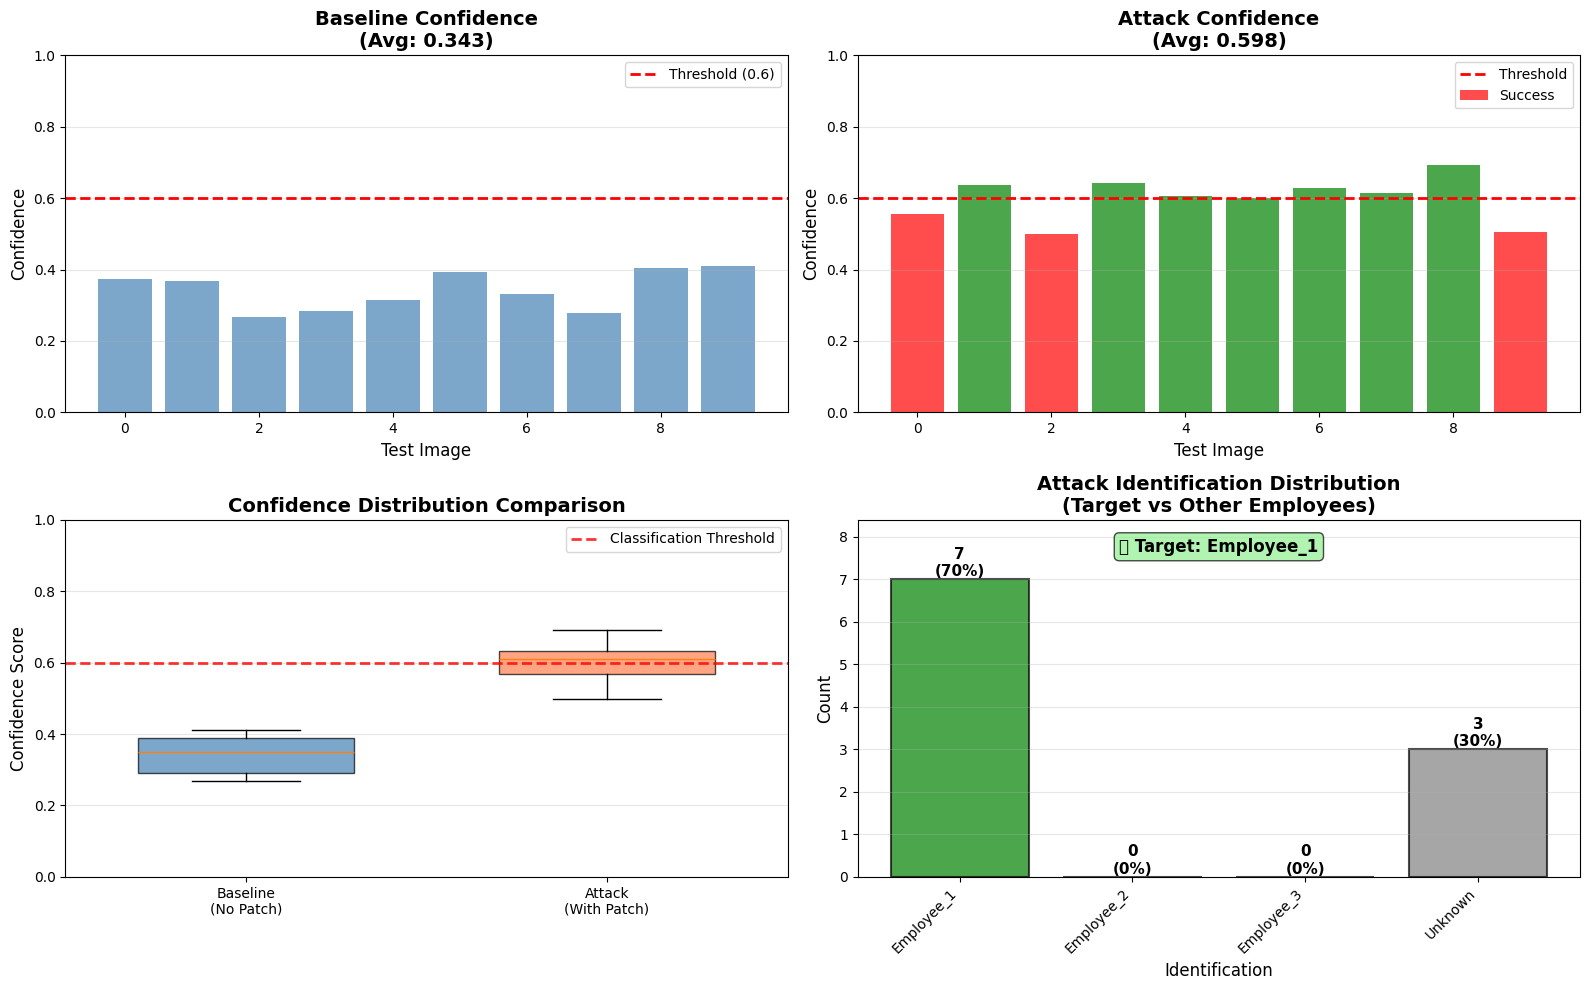


DETAILED PER-IMAGE RESULTS WITH ALL EMPLOYEE SIMILARITIES

📋 BASELINE (Without Patch):
Image    Identified      Conf     OK?   | Employee_1   Employee_2   Employee_3   
────────────────────────────────────────────────────────────────────────────────────────────────────
1        Unknown         0.374    ✓     | 0.234        0.245        0.374        
2        Unknown         0.368    ✓     | 0.344        0.104        0.368        
3        Unknown         0.268    ✓     | 0.183        0.146        0.268        
4        Unknown         0.283    ✓     | 0.283        0.071        0.275        
5        Unknown         0.315    ✓     | 0.180        0.192        0.315        
6        Unknown         0.394    ✓     | 0.235        0.186        0.394        
7        Unknown         0.331    ✓     | 0.296        0.041        0.331        
8        Unknown         0.277    ✓     | 0.277        0.173        0.242        
9        Unknown         0.405    ✓     | 0.405        0.000        0.227

In [58]:
# ============================================================================
# ENHANCED METRICS AND ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("COMPREHENSIVE METRICS ANALYSIS")
print("="*70)

# Calculate detailed metrics
total_baseline_tests = len(baseline_results)
total_attack_tests = len(attack_results)

# Baseline metrics
baseline_unknown = sum(1 for (identified, _) in baseline_results if identified == "Unknown")
baseline_misidentified = sum(1 for (identified, _) in baseline_results if identified != "Unknown")
baseline_accuracy = (baseline_unknown / total_baseline_tests * 100) if total_baseline_tests > 0 else 0

# Attack metrics
attack_success = sum(1 for (identified, _) in attack_results if identified == target_employee)
attack_failed = sum(1 for (identified, _) in attack_results if identified != target_employee)
attack_success_rate = (attack_success / total_attack_tests * 100) if total_attack_tests > 0 else 0

# NEW: Count identifications for each employee during attack
employee_identifications = {}
for emp_name in employee_embeddings.keys():
    count = sum(1 for (identified, _) in attack_results if identified == emp_name)
    employee_identifications[emp_name] = count

# Confidence statistics
baseline_confidences = [conf for (_, conf) in baseline_results]
attack_confidences = [conf for (_, conf) in attack_results]

baseline_avg_conf = np.mean(baseline_confidences) if baseline_confidences else 0
baseline_max_conf = np.max(baseline_confidences) if baseline_confidences else 0
baseline_min_conf = np.min(baseline_confidences) if baseline_confidences else 0

attack_avg_conf = np.mean(attack_confidences) if attack_confidences else 0
attack_max_conf = np.max(attack_confidences) if attack_confidences else 0
attack_min_conf = np.min(attack_confidences) if attack_confidences else 0

# Attack success confidence (only successful attacks)
successful_attack_confidences = [conf for (identified, conf) in attack_results if identified == target_employee]
success_avg_conf = np.mean(successful_attack_confidences) if successful_attack_confidences else 0

print("\n📊 BASELINE PERFORMANCE (No Patch)")
print("─" * 70)
print(f"Total tests: {total_baseline_tests}")
print(f"Correctly identified as 'Unknown': {baseline_unknown} ({baseline_accuracy:.1f}%)")
print(f"Misidentified as employee: {baseline_misidentified} ({100-baseline_accuracy:.1f}%)")
print(f"\nConfidence Statistics:")
print(f"  Average: {baseline_avg_conf:.3f}")
print(f"  Range: [{baseline_min_conf:.3f}, {baseline_max_conf:.3f}]")

print("\n🎯 ATTACK PERFORMANCE (With Patch)")
print("─" * 70)
print(f"Total tests: {total_attack_tests}")
print(f"Successfully fooled as '{target_employee}': {attack_success} ({attack_success_rate:.1f}%)")
print(f"Attack failed: {attack_failed} ({100-attack_success_rate:.1f}%)")
print(f"\nIdentification Breakdown (shows specificity to target):")
for emp_name, count in employee_identifications.items():
    percentage = (count / total_attack_tests * 100) if total_attack_tests > 0 else 0
    marker = "🎯 TARGET" if emp_name == target_employee else "        "
    print(f"  {marker} {emp_name}: {count}/{total_attack_tests} ({percentage:.1f}%)")
unknown_count = sum(1 for (identified, _) in attack_results if identified == "Unknown")
unknown_percentage = (unknown_count / total_attack_tests * 100) if total_attack_tests > 0 else 0
print(f"           Unknown: {unknown_count}/{total_attack_tests} ({unknown_percentage:.1f}%)")
print(f"\nConfidence Statistics:")
print(f"  Average (all attempts): {attack_avg_conf:.3f}")
print(f"  Average (successful only): {success_avg_conf:.3f}")
print(f"  Range: [{attack_min_conf:.3f}, {attack_max_conf:.3f}]")

print("\n📈 COMPARATIVE ANALYSIS")
print("─" * 70)
confidence_increase = attack_avg_conf - baseline_avg_conf
print(f"Average confidence change: {confidence_increase:+.3f} ({confidence_increase/baseline_avg_conf*100:+.1f}%)")
print(f"Attack effectiveness: {attack_success_rate:.1f}% success rate")
print(f"System vulnerability: {baseline_accuracy:.1f}% → {100-attack_success_rate:.1f}% accuracy")

# Calculate how many crossed the threshold
baseline_above_threshold = sum(1 for conf in baseline_confidences if conf >= 0.6)
attack_above_threshold = sum(1 for conf in attack_confidences if conf >= 0.6)

print(f"\nThreshold (0.6) Analysis:")
print(f"  Baseline above threshold: {baseline_above_threshold}/{total_baseline_tests} ({baseline_above_threshold/total_baseline_tests*100:.1f}%)")
print(f"  Attack above threshold: {attack_above_threshold}/{total_attack_tests} ({attack_above_threshold/total_attack_tests*100:.1f}%)")

# Determine overall attack quality
print("\n" + "="*70)
print("ATTACK QUALITY ASSESSMENT")
print("="*70)

if attack_success_rate >= 80:
    quality = "EXCELLENT ⭐⭐⭐"
    assessment = "Highly effective attack! The patch consistently fools the system."
elif attack_success_rate >= 60:
    quality = "GOOD ⭐⭐"
    assessment = "Effective attack with moderate success rate."
elif attack_success_rate >= 40:
    quality = "MODERATE ⭐"
    assessment = "Partially effective. Consider increasing patch size or training iterations."
else:
    quality = "POOR"
    assessment = "Attack needs significant improvement. Try different parameters."

print(f"\nOverall Rating: {quality}")
print(f"Assessment: {assessment}")

if success_avg_conf >= 0.7:
    print(f"✓ High confidence in successful attacks ({success_avg_conf:.3f})")
elif success_avg_conf >= 0.6:
    print(f"✓ Moderate confidence in successful attacks ({success_avg_conf:.3f})")
else:
    print(f"⚠ Low confidence even when successful ({success_avg_conf:.3f})")

# Check specificity
non_target_identifications = sum(count for emp_name, count in employee_identifications.items() if emp_name != target_employee)
if attack_success > 0 and non_target_identifications == 0:
    print(f"✓ Perfect specificity: Only identified as target employee, never confused with others")
elif attack_success > non_target_identifications:
    print(f"✓ Good specificity: Mostly identified as target ({attack_success} vs {non_target_identifications} wrong employees)")
else:
    print(f"⚠ Poor specificity: Often confused with wrong employees")

# Visualization of confidence distributions
print("\n" + "="*70)
print("CONFIDENCE DISTRIBUTION VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Baseline confidence distribution
axes[0, 0].bar(range(len(baseline_confidences)), baseline_confidences, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=0.6, color='red', linestyle='--', linewidth=2, label='Threshold (0.6)')
axes[0, 0].set_xlabel('Test Image', fontsize=12)
axes[0, 0].set_ylabel('Confidence', fontsize=12)
axes[0, 0].set_title(f'Baseline Confidence\n(Avg: {baseline_avg_conf:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Attack confidence distribution
colors = ['green' if identified == target_employee else 'red'
          for (identified, _) in attack_results]
axes[0, 1].bar(range(len(attack_confidences)), attack_confidences, color=colors, alpha=0.7)
axes[0, 1].axhline(y=0.6, color='red', linestyle='--', linewidth=2, label='Threshold (0.6)')
axes[0, 1].set_xlabel('Test Image', fontsize=12)
axes[0, 1].set_ylabel('Confidence', fontsize=12)
axes[0, 1].set_title(f'Attack Confidence\n(Avg: {attack_avg_conf:.3f})', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].legend(['Threshold', 'Success', 'Failed'], loc='upper right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Box plot comparison
box_data = [baseline_confidences, attack_confidences]
labels = ['Baseline\n(No Patch)', 'Attack\n(With Patch)']
colors_box = ['steelblue', 'coral']

bp = axes[1, 0].boxplot(box_data, labels=labels, patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 0].axhline(y=0.6, color='red', linestyle='--', linewidth=2, label='Classification Threshold', alpha=0.8)
axes[1, 0].set_ylabel('Confidence Score', fontsize=12)
axes[1, 0].set_title('Confidence Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 1)

# NEW: Employee identification breakdown
emp_names = list(employee_embeddings.keys())
emp_counts = [employee_identifications[name] for name in emp_names]
emp_counts.append(unknown_count)
labels_emp = emp_names + ['Unknown']
colors_emp = ['green' if name == target_employee else 'lightcoral' for name in emp_names] + ['gray']

bars = axes[1, 1].bar(range(len(labels_emp)), emp_counts, color=colors_emp, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('Identification', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Attack Identification Distribution\n(Target vs Other Employees)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(range(len(labels_emp)))
axes[1, 1].set_xticklabels(labels_emp, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim(0, max(emp_counts + [1]) * 1.2)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, emp_counts)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{count}\n({count/total_attack_tests*100:.0f}%)',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# Highlight target
axes[1, 1].text(0.5, 0.95, f'🎯 Target: {target_employee}',
                transform=axes[1, 1].transAxes,
                fontsize=12, fontweight='bold',
                ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

# NEW: Detailed per-image breakdown with per-employee similarities
print("\n" + "="*70)
print("DETAILED PER-IMAGE RESULTS WITH ALL EMPLOYEE SIMILARITIES")
print("="*70)

print("\n📋 BASELINE (Without Patch):")
print(f"{'Image':<8} {'Identified':<15} {'Conf':<8} {'OK?':<5} | ", end="")
for emp_name in employee_embeddings.keys():
    print(f"{emp_name:<12}", end=" ")
print()
print("─" * 100)

# Recalculate similarities for baseline
for idx, test_img in enumerate(attacker_test_images):
    try:
        test_embedding = get_face_embedding(test_img)
        if test_embedding is not None and idx < len(baseline_results):
            identified, conf = baseline_results[idx]
            is_correct = "✓" if identified == "Unknown" else "✗"
            print(f"{idx+1:<8} {identified:<15} {conf:<8.3f} {is_correct:<5} | ", end="")

            # Calculate similarity to each employee
            for emp_name, emp_emb in employee_embeddings.items():
                similarity = cosine_similarity(test_embedding, emp_emb)
                print(f"{similarity:<12.3f}", end=" ")
            print()
    except Exception as e:
        print(f"{idx+1:<8} Error in baseline: {str(e)}")

print("\n📋 ATTACK (With Patch) - Shows specificity to target:")
print(f"{'Image':<8} {'Identified':<15} {'Conf':<8} {'OK?':<5}")
print("─" * 60)
print("Note: Full similarity recalculation requires access to patch variables.")
print("      Showing identification results from attack test:")
print()

# Show attack results without recalculating (to avoid scope issues)
for idx, (identified, conf) in enumerate(attack_results):
    is_success = "✓" if identified == target_employee else "✗"
    marker = "🎯" if identified == target_employee else "  "
    print(f"{idx+1:<8} {marker}{identified:<15} {conf:<8.3f} {is_success:<5}")

print("\nInterpretation:")
print(f"- Target employee: {target_employee}")
print(f"- Successful attacks: {attack_success}/{total_attack_tests}")
print(f"- Non-target identifications: {sum(1 for (id, _) in attack_results if id != target_employee and id != 'Unknown')}")

print("\nNote: 🎯 indicates the target employee. High similarity to target and low")
print("      similarity to other employees demonstrates attack specificity.")

print("\n" + "="*70)
print("✓ Enhanced metrics analysis complete!")
print("="*70)